In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('online_retail_II.csv', parse_dates=True, index_col='InvoiceDate')

In [7]:
df.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country
InvoiceDate,,,,,,,
2009-12-01 07:45:00,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom
2009-12-01 07:45:00,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom


In [8]:
df_time = df[(df.index>='2011-04-01') & (df.index<='2011-12-09')]

In [9]:
df_time.isnull().sum()

Invoice            0
StockCode          0
Description      985
Quantity           0
Price              0
Customer ID    88936
Country            0
dtype: int64

In [10]:
df_time = df_time[df_time['Customer ID'].notna()]

In [11]:
df_time = df_time[~df_time.Invoice.str.contains('C')]

In [12]:
df_time[df_time.duplicated()].shape

(3932, 7)

In [13]:
df_time = df_time.drop_duplicates(keep='first')

In [14]:
print((df_time.Quantity<0).sum())
print((df_time.Price<0).sum())

0
0


In [15]:
# calculating Recency
df_time['R'] = 12 - df_time.index.month

In [16]:
# creating a new column and initializing to 0
df_time['F'] = 0

# creating a list of unique customer ids
customer_ids = list(df_time['Customer ID'].unique())

# calculating and storing the number of transactions made by each customer
for id in customer_ids:
  df_time.loc[df_time['Customer ID']==id, 'F'] += df_time.groupby(by='Customer ID').Invoice.size()[id]

In [17]:
# calculating and storing the revenue
df_time['Revenue'] = df_time.Quantity * df_time.Price

In [18]:
# creating a new column and initializing to 0
df_time['M'] = 0

# adding the sum of the revenue generated by each customer
for id in customer_ids:
  df_time.loc[df_time['Customer ID']==id, 'M'] += df_time.groupby(by='Customer ID').Revenue.sum()[id]

In [19]:
# creating a new dataframe
df_rfm = pd.DataFrame(customer_ids, columns=['Customer ID'])

In [20]:
# creating new columns and initializing to 0
df_rfm['R'] = 0
df_rfm['F'] = 0
df_rfm['M'] = 0

# updating value of each column
for id in customer_ids:
    df_rfm.loc[df_rfm['Customer ID']==id, 'R'] += df_time.loc[df_time['Customer ID']==id, 'R'].values[0]
    df_rfm.loc[df_rfm['Customer ID']==id, 'F'] += df_time.loc[df_time['Customer ID']==id, 'F'].values[0]
    df_rfm.loc[df_rfm['Customer ID']==id, 'M'] += df_time.loc[df_time['Customer ID']==id, 'M'].values[0]

In [21]:
from sklearn.cluster import KMeans

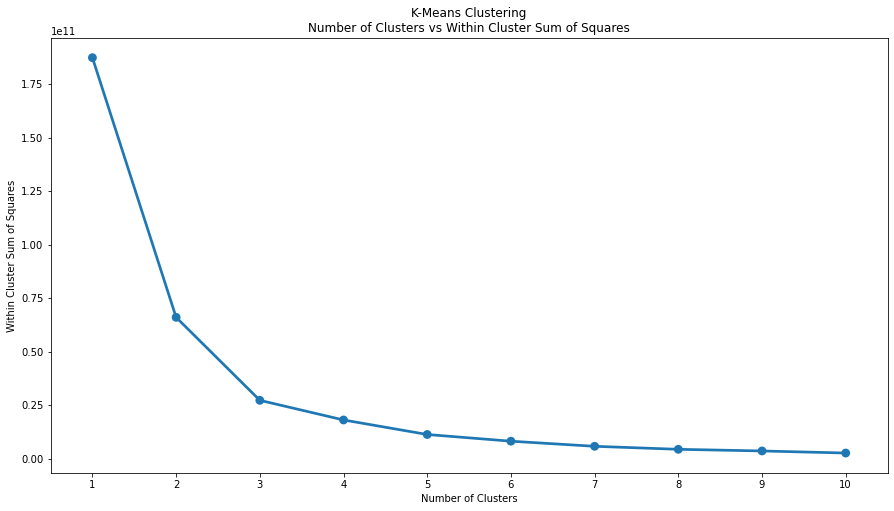

In [22]:
# creating a list to store the within-the-cluster-sum-of-squared-distance
wcss = []

# looping over number of clusters and storing wcss
for k in range(0, 10):
  kmeans = KMeans(n_clusters=k+1, random_state=0).fit(df_rfm[['R', 'F', 'M']])
  wcss.append(kmeans.inertia_)

# plotting the wcss wrt cluster numbers
plt.figure(figsize=(15,8))
ax = sns.pointplot(x=list(range(1, 11)), y=wcss)
ax.set_title('K-Means Clustering\nNumber of Clusters vs Within Cluster Sum of Squares')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Within Cluster Sum of Squares')
plt.show()

In [23]:
# building the kmeans model
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_rfm[['R', 'F', 'M']])

In [24]:
# generating cluster labels
df_rfm['labels'] = kmeans.labels_

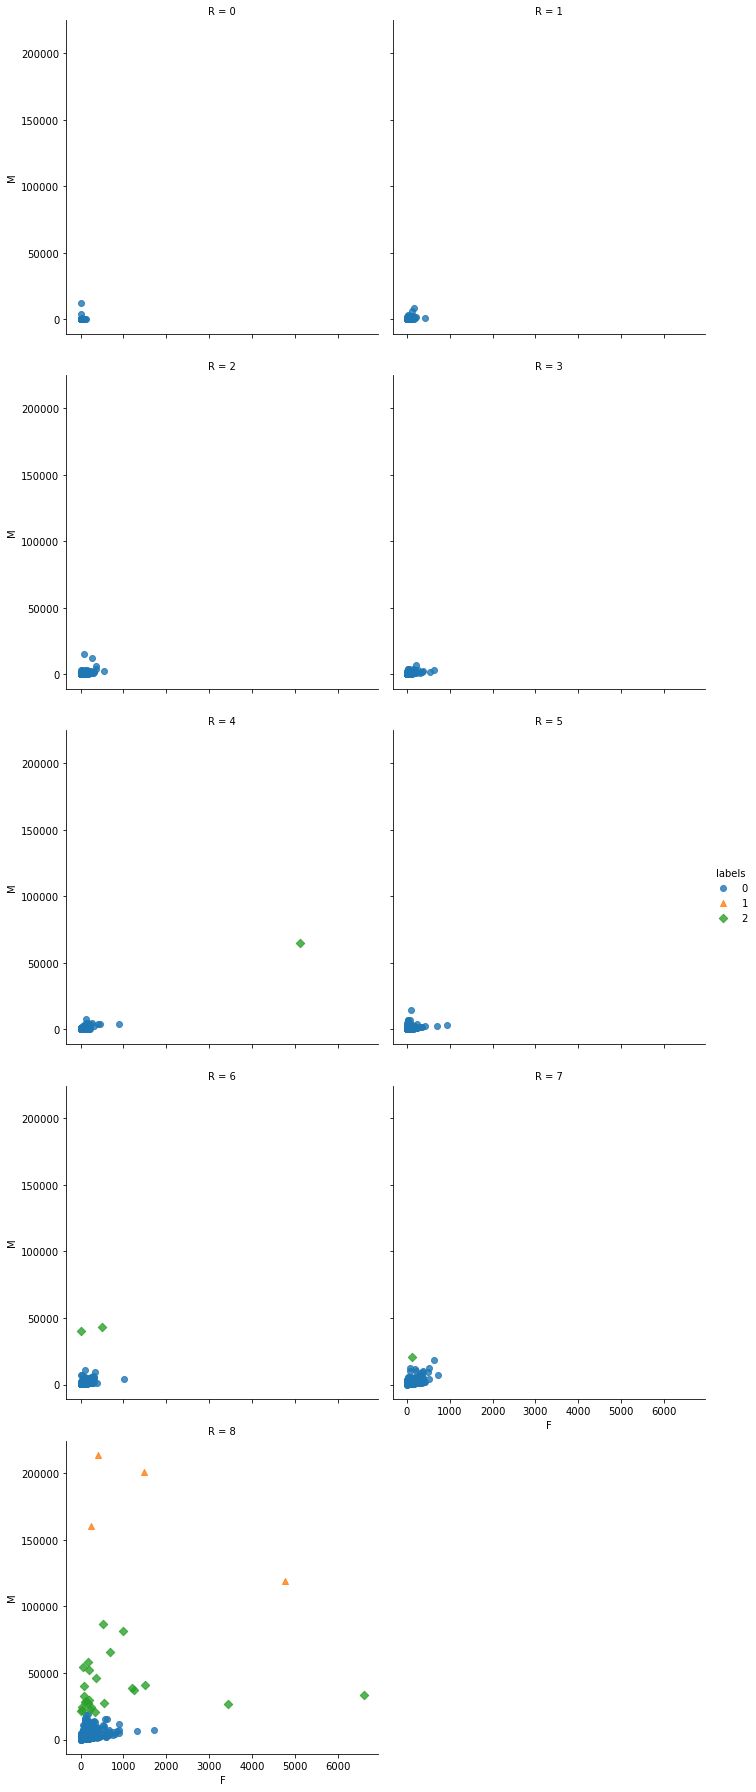

In [25]:
# visualizing the clusters
sns.lmplot(x='F', y='M', col='R', hue='labels', data=df_rfm, col_wrap=2, fit_reg=False, markers=['o', '^', 'D'])

In [26]:
# printing the cluster centres
kmeans.cluster_centers_

array([[5.00209644e+00, 6.99821803e+01, 1.22842223e+03],
       [8.00000000e+00, 1.72525000e+03, 1.73486923e+05],
       [7.68965517e+00, 8.59482759e+02, 3.93992303e+04]])

In [27]:
from sklearn.cluster import AgglomerativeClustering

In [28]:
# building agglomerative clustering model
agglo = AgglomerativeClustering(n_clusters=3, compute_distances=True).fit(df_rfm[['R','F','M']])

In [29]:
from scipy.cluster.hierarchy import dendrogram

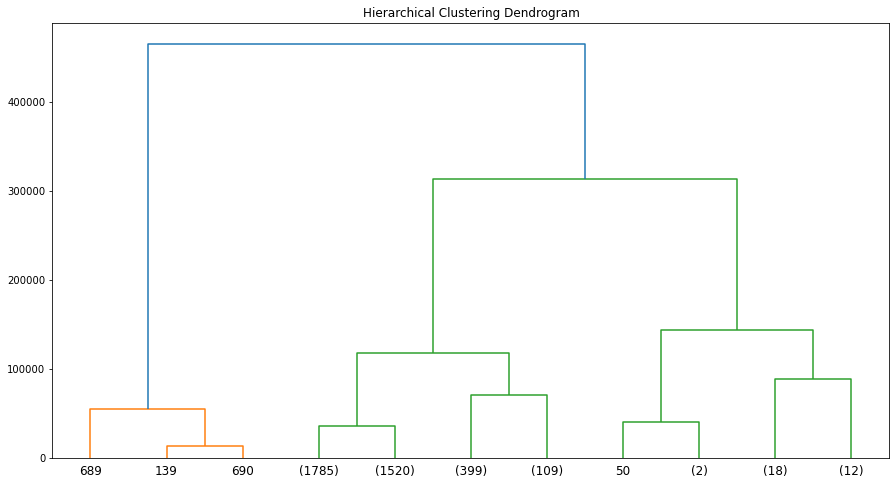

In [30]:
def plot_dendrogram(agglo, **kwargs):
    
    counts = np.zeros(agglo.children_.shape[0])
    n_samples = len(agglo.labels_)
    for i, merge in enumerate(agglo.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([agglo.children_, agglo.distances_, counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)
    

plt.figure(figsize=(15,8))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agglo, truncate_mode='level', p=3)
plt.show()

In [31]:
# creating a list of labels generated by the kmeans model
labels_kmeans = list(kmeans.labels_)

# creating a list of labels generated by the agglomerative clustering model
labels_agglo = list(agglo.labels_)

In [32]:
# printing the size of the kmeans clusters
print('Cluster 0 - KMeans: ', labels_kmeans.count(0))
print('Cluster 1 - KMeans: ', labels_kmeans.count(1))
print('Cluster 2 - KMeans: ', labels_kmeans.count(2))

print()

# printing the size of the agglomerative clusters
print('Cluster 0 - Agglomerative: ', labels_agglo.count(0))
print('Cluster 1 - Agglomerative: ', labels_agglo.count(1))
print('Cluster 2 - Agglomerative: ', labels_agglo.count(2))

Cluster 0 - KMeans:  3816
Cluster 1 - KMeans:  4
Cluster 2 - KMeans:  29

Cluster 0 - Agglomerative:  33
Cluster 1 - Agglomerative:  3
Cluster 2 - Agglomerative:  3813
